In [1]:
import math
import time
import copy
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from FairDebugger import Dataset, FairnessMetric, FairnessDebuggingUsingMachineUnlearning

# Dataset class

In [2]:
'''Class for loading and preprocessing german credits dataset'''
class GermanCreditDataset(Dataset): 
    def __init__(self, rootTrain, rootTest):
        Dataset.__init__(self, rootTrain = rootTrain, rootTest = rootTest)
#         self.train = pd.DataFrame()
#         self.test = pd.DataFrame()
        self.train = self.trainDataset
        self.test = self.testDataset
        self.__renameColumnNames()
#         self.__initiateTrainTestSplit()
        self.trainProcessed, self.testProcessed = self.__preprocessDataset(self.train), self.__preprocessDataset(self.test)
        self.trainLattice, self.testLattice = self.__preprocessDatasetForCategorization(self.train), self.__preprocessDatasetForCategorization(self.test)
        
    def getDataset(self):
        return self.dataset, self.train, self.test

    def getDatasetWithNormalPreprocessing(self):
        return self.trainProcessed, self.testProcessed
    
    def getDatasetWithCategorizationPreprocessing(self, decodeAttributeValues = False):
        if decodeAttributeValues == True:
            return self.__decodeAttributeCodeToRealValues(self.trainLattice), self.__decodeAttributeCodeToRealValues(self.testLattice)
        return self.trainLattice, self.testLattice

    def __renameColumnNames(self):
        columns={'Column1': 'status_chec_acc', 
                'Column2': 'duration',
                'Column3': 'cred_hist',
                'Column4': 'purpose',
                'Column5': 'cred_amt',
                'Column6': 'savings',
                'Column7': 'employment',
                'Column8': 'intallment_rate',
                'Column9': 'status_and_sex',
                'Column10': 'debtors',
                'Column11': 'present_resi_since',
                'Column12': 'property',
                'Column13': 'age',
                'Column14': 'install_plans',
                'Column15': 'housing',
                'Column16': 'existing_creds',
                'Column17': 'job',
                'Column18': 'num_people_liable_to_maint',
                'Column19': 'telephone',
                'Column20': 'foreign_worker',
                'Column21': 'status'}
#         self.dataset.rename(columns = columns, inplace = True)
        self.train.rename(columns = columns, inplace = True)
        self.test.rename(columns = columns, inplace = True)
        
    def __initiateTrainTestSplit(self):
        trainX, testX, trainY, testY = train_test_split(self.dataset.drop('status', axis = 1) , 
                                                self.dataset['status'], 
                                                stratify = self.dataset['status'], 
                                                test_size=0.2)
        trainX['status'] = trainY
        testX['status'] = testY
        self.train = trainX.reset_index(drop = True)
        self.test = testX.reset_index(drop = True)

    def __preprocessDataset(self, dataset):
        df = copy.deepcopy(dataset)
        df['status_chec_acc'] = df['status_chec_acc'].map({'A11': 0, 'A12': 1, 'A13': 2, 'A14': 3}).astype(int, errors='ignore')
        df['cred_hist'] = df['cred_hist'].map({'A34': 0, 'A33': 1, 'A32': 2, 'A31': 3, 'A30': 4}).astype(int, errors='ignore')
        df['savings'] = df['savings'].map({'A61': 0, 'A62': 1, 'A63': 2, 'A64': 3, 'A65': 4}).astype(int)
        df['employment'] = df['employment'].map({'A71': 0, 'A72': 1, 'A73': 2, 'A74': 3, 'A75': 4}).astype(int)    
        df['sex'] = df['status_and_sex'].map({'A91': 1, 'A92': 0, 'A93': 1, 'A94': 1, 'A95': 0}).astype(int)
        df['debtors'] = df['debtors'].map({'A101': 0, 'A102': 1, 'A103': 2}).astype(int)
        df['property'] = df['property'].map({'A121': 3, 'A122': 2, 'A123': 1, 'A124': 0}).astype(int)        
        df['install_plans'] = df['install_plans'].map({'A141': 1, 'A142': 1, 'A143': 0}).astype(int)    
        df = pd.concat([df, pd.get_dummies(df['purpose'], prefix='purpose')],axis=1)
        df = pd.concat([df, pd.get_dummies(df['housing'], prefix='housing')],axis=1)
        df = pd.concat([df, pd.get_dummies(df['status_and_sex'], prefix='status_and_sex')],axis=1)
        df.loc[(df['cred_amt'] <= 2000), 'cred_amt'] = 0
        df.loc[(df['cred_amt'] > 2000) & (df['cred_amt'] <= 5000), 'cred_amt'] = 1
        df.loc[(df['cred_amt'] > 5000), 'cred_amt'] = 2    
        df.loc[(df['duration'] <= 12), 'duration'] = 0
        df.loc[(df['duration'] > 12) & (df['duration'] <= 24), 'duration'] = 1
        df.loc[(df['duration'] > 24) & (df['duration'] <= 36), 'duration'] = 2
        df.loc[(df['duration'] > 36), 'duration'] = 3
        df['age'] = df['age'].apply(lambda x : 1 if x > 30 else 0) # 1 if old, 0 if young
        df['job'] = df['job'].map({'A171': 0, 'A172': 1, 'A173': 2, 'A174': 3}).astype(int)    
        df['telephone'] = df['telephone'].map({'A191': 0, 'A192': 1}).astype(int)
        df['foreign_worker'] = df['foreign_worker'].map({'A201': 1, 'A202': 0}).astype(int)
        df['status'] = df['status'].map({1: 1, 2: 0}).astype(int, errors='ignore')
        df.drop(columns=['purpose', 'status_and_sex','housing'], inplace = True)
        '''Moving status column at the end'''
        cols = list(df.columns.values) 
        cols.pop(cols.index('status')) 
        df = df[cols+['status']]
        return df
    
    def __preprocessDatasetForCategorization(self, dataset):
        df = copy.deepcopy(dataset)
        non_object_columns = [col for col in df.columns if df[col].dtypes != 'object']
        quantiles = self.train[non_object_columns].quantile([0, .25, .5, .75, 1.0], axis = 0)
        for col in non_object_columns:
            if col == 'age':
                df[col] = pd.cut(df[col], 
                               [quantiles[col][0.0] - 1, 30, quantiles[col][1.0] + 1], 
                               labels = ['age = young', 'age = old'], 
                               right = True, 
                               include_lowest = True)
            elif col == 'status':
                continue
            elif col == 'cred_amt':
                df[col] = pd.cut(df[col], 
                               [0, 1365.50001, 3972.25001, 18424.0001], 
                               labels = [str(col) + ' = low', str(col) + ' = medium', str(col) + ' = high'], 
                               right = True, 
                               include_lowest = True)
            else:
                df[col] = pd.cut(df[col], 
                               [quantiles[col][0.0] - 1, quantiles[col][0.50], math.inf], 
                               labels = [str(col) + ' = low', str(col) + ' = high'], 
                               right = True, 
                               include_lowest = True)
        df['status'] = df['status'].map({1: 1, 2: 0}).astype(int, errors='ignore')
        '''Moving status column at the end'''
        cols = list(df.columns.values) 
        cols.pop(cols.index('status')) 
        df = df[cols+['status']]
        return df
    
    def __decodeAttributeCodeToRealValues(self, dataset):
        df = copy.deepcopy(dataset)
        map_code_to_real = {
            "status_chec_acc": {
                "A11": "status_chec_acc = < 0 DM",
                "A12": "status_chec_acc = 0 <=..< 200DM",
                "A13": "status_chec_acc = > =200 DM",
                "A14": "status_chec_acc = no checking account"
            },
            "cred_hist": {
                "A30": "cred_hist = no credits taken / all credits paid back duly",
                "A31": "cred_hist = all credits at this bank paid back duly",
                "A32": "cred_hist = existing credits paid back duly till now",
                "A33": "cred_hist = delay in paying off in the past",
                "A34": "cred_hist = critical account / other credits existing (not at this bank)"
            },
            "purpose": {
                "A40": "purpose = car (new)",
                "A41": "purpose = car (used)",
                "A42": "purpose = furniture/equipment",
                "A43": "purpose = radio/television",
                "A44": "purpose = domestic appliances",
                "A45": "purpose = repairs",
                "A46": "purpose = education",
                "A47": "purpose = vacation - does not exist?",
                "A48": "purpose = retraining",
                "A49": "purpose = business",
                "A410": "purpose = others"
            },
            "savings": {
                "A61": "savings = ..<100 DM",
                "A62": "savings = 100 <= .. < 500 DM",
                "A63": "savings = 500 <= .. < 1000 DM",
                "A64" : "savings = ..>=1000 DM",
                "A65": "unknown/no savings account"
            },
            "employment": {
                "A71": "employment = unemployed",
                "A72": "employment = .. < 1 year",
                "A73": "employment = 1 <= .. < 4 years",
                "A74": "employment = 4 <= .. < 7 years",
                "A75": "employment = .. >= 7 years"
            },
            "status_and_sex": {
                "A91": "status_and_sex = male: divorced/separated",
                "A92": "status_and_sex = female: divorced/separated/married",
                "A93": "status_and_sex = male: single",
                "A94": "status_and_sex = male: married/widowed",
                "A95": "status_and_sex = femaled: single"
            },
            "debtors": {
                "A101": "debtors = none",
                "A102": "debtors = co-applicant",
                "A103": "debtors = guarantor"
            },
            "property": {
                "A121": "property = real estate",
                "A122": "property = building society savings agreement/life insurance",
                "A123": "property = car or other",
                "A124": "property = unknown / no property"
            },
            "install_plans": {
                "A141": "install_plans = bank",
                "A142": "install_plans = stores",
                "A143": "install_plans = none"
            },
            "housing": {
                "A151": "housing = rent",
                "A152": "housing = own",
                "A153": "housing = for free"
            },
            "job": {
                "A171": "job = unemployed / unskilled - non-resident",
                "A172": "job = unskilled - resident",
                "A173": "job = skilled employee / official",
                "A174": "job = management / self-employed / highly qualified employee / officer" 
            },
            "telephone": {
                "A191": "telephone = none",
                "A192": "telephone = yes, registered under customer's name"
            },
            "foreign_worker": {
                "A201": "foreign_worker = yes",
                "A202": "foreign_worker = no"
            }
        }
        object_columns = [col for col in df.columns if df[col].dtypes == 'object']
        for col in object_columns:
            df[col] = df[col].map(map_code_to_real[col]).fillna(df[col])
        return df

# Testing

In [3]:
myDataset = GermanCreditDataset(rootTrain = 'Dataset/german_train.csv', rootTest = 'Dataset/german_test.csv')

In [5]:
fairnessDebug = FairnessDebuggingUsingMachineUnlearning(myDataset,
                                                        ["age", 1, 0],
                                                        "status",
                                                        FairnessMetric.EO)
print("OriginalAccuracy: " + fairnessDebug.getAccuracy() + ", originalSP: " + str(fairnessDebug.getDatasetStatisticalParity()) + ", originalPP: " + str(fairnessDebug.getDatasetPredictiveParity()) + ", originalEO: " + str(fairnessDebug.getDatasetEqualizingOddsParity()))

OriginalAccuracy: 73.0%, originalSP: 0.065550041356493, originalPP: 0.12070771737865205, originalEO: 0.06063829787234043


level: 0
level: 1
level: 2
level: 3


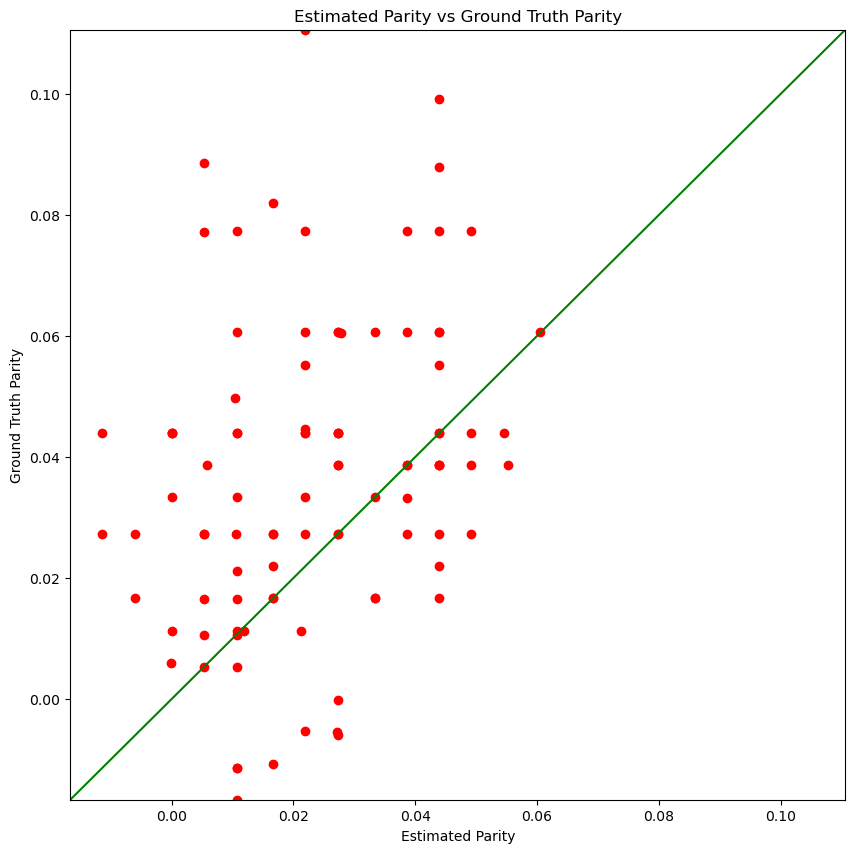

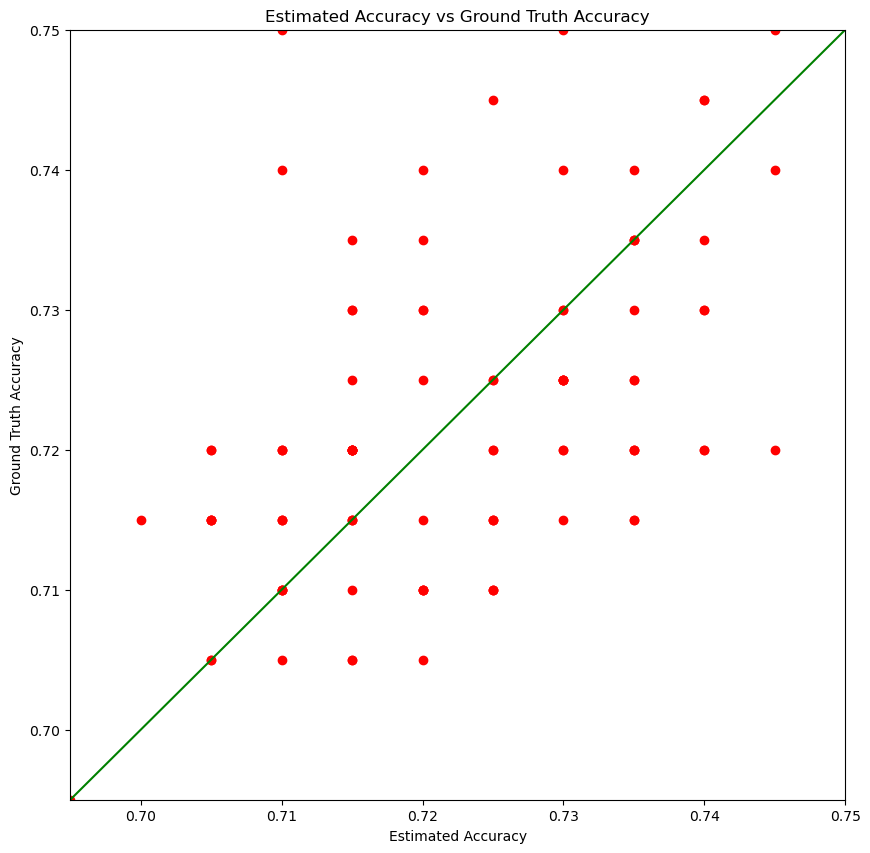

,Subset,Size,Support,Parity,GT_Parity,Accuracy,GT_Accuracy,timeElapsedToTrain,timeElapsedToDelete,Parity_Reduction,Accuracy_Reduction
0,"{'status_chec_acc = < 0 DM', 'cred_amt = high'}",51,0.06375,0.0,0.04397163120567377,0.71,0.715,0.03601694107055664,0.016766071319580078,100.000000,2.739726027397263
1,{'status_and_sex = female: divorced/separated/...,114,0.1425,0.0,0.033333333333333326,0.71,0.74,0.04070901870727539,0.01743602752685547,100.000000,2.739726027397263
2,"{'present_resi_since = high', 'employment = 1 ...",85,0.10625,0.0,0.04397163120567377,0.74,0.745,0.04104351997375488,0.015025854110717773,100.000000,-1.3698630136986314
3,"{'duration = high', 'job = unskilled - resident'}",50,0.0625,0.0,0.04397163120567377,0.71,0.715,0.04002046585083008,0.012037992477416992,100.000000,2.739726027397263
4,"{'property = unknown / no property', 'duration...",48,0.06,0.0,0.011290322580645162,0.72,0.71,0.040021657943725586,0.012002944946289062,100.000000,1.3698630136986314
...,...,...,...,...,...,...,...,...,...,...,...
91,"{'intallment_rate = low', 'purpose = furniture...",82,0.1025,0.04923358499199265,0.027304964539007104,0.725,0.71,0.04002094268798828,0.012038469314575195,18.807772,0.6849315068493157
92,"{'purpose = furniture/equipment', 'install_pla...",115,0.14375,0.04923358499199265,0.07730496453900709,0.715,0.725,0.036045074462890625,0.016004562377929688,18.807772,2.054794520547947
93,"{'employment = 4 <= .. < 7 years', 'telephone ...",71,0.08875,0.05460992907801415,0.04397163120567377,0.73,0.725,0.04028582572937012,0.016013145446777344,9.941520,0.0
94,"{'purpose = furniture/equipment', 'cred_amt = ...",92,0.115,0.05526195378631893,0.038595287119652266,0.725,0.71,0.03705143928527832,0.012042045593261719,8.866252,0.6849315068493157


In [5]:
explanations = fairnessDebug.latticeSearchSubsets(4, (0.05, 0.15), "normal", True)
explanations

# How good are the explanations?

In [6]:
# Example subsets to check why they are bias-inducing
subsets = [{'cred_amt = high', 'status_chec_acc = < 0 DM'},
{'status_and_sex = female: divorced/separated/married', 'present_resi_since = high'},
{'present_resi_since = high', 'employment = 1 <= .. < 4 years'},
{'duration = high', 'job = unskilled - resident'},
{'property = unknown / no property', 'duration = low'}
]

In [7]:
featImp = fairnessDebug.getFeatureImportanceChanges(subsets)
featImp

,Subset,status_chec_acc,cred_hist,duration,savings,employment,property,install_plans,intallment_rate,cred_amt,...,status_and_sex_A93,housing_A153,status_and_sex_A94,purpose_A42,status_and_sex_A91,foreign_worker,purpose_A45,purpose_A410,purpose_A48,purpose_A44
0,"{'cred_amt = high', 'status_chec_acc = < 0 DM'}",5.846986041343155,3.3769490650420537,-33.42901703452499,-13.359461098654394,33.6905643748547,6.181005260558343,-24.149407319142654,-0.7053447803075308,-31.986488832632393,...,16.959594551970405,68.87577679559551,-32.23478923479606,39.92307632050638,101.86496471225021,38.763584197286214,6.8842702620860905,106.96688849772035,-45.71181321273568,373.55671208573403
1,{'status_and_sex = female: divorced/separated/...,7.384630649892286,-5.4311180022636245,-12.106460688878077,-13.822776930649619,1.1046268269225228,0.4805033954618669,-36.068465211179635,6.09498296927269,4.572129063715055,...,-3.0167141274089526,52.693443104167876,11.298883076927,76.00036946235507,92.77205553858917,56.20565812256853,76.83929669839723,11.767881020185394,-12.13126851505219,215.28938516259726
2,"{'employment = 1 <= .. < 4 years', 'present_re...",5.21494629425202,15.69424212388612,0.1469662893047147,8.805260954364197,1.9229017003338311,-9.334288902361715,-21.33229832708322,-4.155968614953613,8.292723258866504,...,59.51106746861503,29.71060472793699,-13.066762369574647,-31.200775833810756,86.76651277929301,-40.86835019904746,24.621223714079377,0.3144058808684235,-62.14195786303582,-14.222251919112404
3,"{'job = unskilled - resident', 'duration = high'}",16.406101578680367,3.460322307547949,-3.7339361452183035,-8.222925145777733,-21.344938976757806,5.9193872794670686,-25.489496012031026,-36.85550303587089,18.92776256543296,...,90.18407088479886,64.91248118325396,5.437502213296855,7.113818612713503,21.446613639906804,-13.673042739047242,54.972455216882466,-7.528858609305251,36.799655518950644,76.27563598601402
4,"{'property = unknown / no property', 'duration...",-3.725946220321893,0.6861167309086837,1.6618842058423706,-7.546282685351108,5.689721902880852,46.21564473266595,-3.4434524815621184,2.6132017502004925,-8.356873733170021,...,20.359458713632733,52.81872919963706,-28.98989193453455,-0.8438479705641174,16.599711960396967,42.21707012305249,-12.683432354805904,2.152677988362224,-7.322294366257463,64.32918481038793


In [8]:
inference = fairnessDebug.drawInferencesFromResultSubsets(subsets, "Young", "Old")
inference

,Subset,Size,Support,SupportRange,Total_Young,Total_Old,Young_1s,Old_1s,Young_0s,Old_0s
0,Entire Train Dataset,800,1.0,100%,334,466,0.65,0.74,0.35,0.26
1,"{'cred_amt = high', 'status_chec_acc = < 0 DM'}",51,0.06375,5-10%,21,30,0.62,0.7,0.38,0.3
2,{'status_and_sex = female: divorced/separated/...,114,0.1425,10-30%,64,50,0.66,0.72,0.34,0.28
3,"{'employment = 1 <= .. < 4 years', 'present_re...",85,0.10625,10-30%,36,49,0.67,0.65,0.33,0.35
4,"{'job = unskilled - resident', 'duration = high'}",50,0.0625,5-10%,24,26,0.62,0.73,0.37,0.27
5,"{'property = unknown / no property', 'duration...",48,0.06,5-10%,6,42,0.67,0.69,0.33,0.31
